In [48]:
!pip install rasterio seaborn

In [49]:
import os
import zipfile
import shutil
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

In [50]:
DATA_PATH = "/kaggle/input/rain-data/DATA_RAIN"
HIMA_PATH = os.path.join(DATA_PATH, "Hima")
ERA5_PATH = os.path.join(DATA_PATH, "ERA5")
RADAR_PATH = os.path.join(DATA_PATH, "Radar")
AWS_PATH = os.path.join(DATA_PATH, "AWS")
RADAR_PATH = os.path.join(DATA_PATH, "Radar")

# 1. Lọc dữ liệu

In [51]:
from multiprocessing import Pool

def count_files_parallel(folder_path):
    total = 0
    stack = [folder_path]
    while stack:
        current = stack.pop()
        with os.scandir(current) as it:
            for entry in it:
                if entry.is_file():
                    total += 1
                elif entry.is_dir():
                    stack.append(entry.path)
    return folder_path, total  


era5_paths = [
    os.path.join(ERA5_PATH, name)
    for name in os.listdir(ERA5_PATH)
    if os.path.isdir(os.path.join(ERA5_PATH, name))
]

folder_paths = [RADAR_PATH]
folder_paths.extend(era5_paths)
folder_paths.sort()
with Pool() as pool:
    results = pool.map(count_files_parallel, folder_paths)


for folder, total_files in results:
    print(f"📂 {folder}: {total_files} files")


📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/CAPE: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/CIN: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/EWSS: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/IE: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/ISOR: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/KX: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/PEV: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/R250: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/R500: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/R850: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/SLHF: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/SLOR: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/SSHF: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/TCLW: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/TCW: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/TCWV: 2928 files
📂 /kaggle/input/rain-data/DATA_RAIN/ERA5/U250: 2928 files
📂 /kaggle/input/rain-

## 1.1. Kiểm tra timestamp Radar

In [52]:
def get_all_timestamps(folder_path, output_csv_path = None):
    timestamps = []

    for year in os.listdir(folder_path):
        year_path = os.path.join(folder_path, year)
        for month in os.listdir(year_path):
            month_path = os.path.join(year_path, month)
            for day in os.listdir(month_path):
                day_path = os.path.join(month_path, day)
                for hour in os.listdir(day_path):
                    timestamps.append([year, month, day, hour])


    timestamps_df = pd.DataFrame(timestamps, columns=["Year", "Month", "Day", "Hour"])
    timestamps_df = timestamps_df.sort_values(by=["Year", "Month", "Day", "Hour"]).reset_index(drop=True)
    if output_csv_path is not None:
        timestamps_df.to_csv(output_csv_path, index=False)
    return timestamps_df

In [53]:
years = [2019, 2020]
months = [4, 10]
days_per_month = {4: range(1, 30 + 1), 10: range(1, 31 + 1)}
hours = range(24)
expected_timestamps = [
    (str(year), f"{month:02}", f"{day:02}", f"{hour:02}")
    for year in years
    for month in months
    for day in days_per_month[month]
    for hour in hours
]
expected_timestamps_df = pd.DataFrame(expected_timestamps, columns=["Year", "Month", "Day", "Hour"])
print(expected_timestamps_df)

      Year Month Day Hour
0     2019    04  01   00
1     2019    04  01   01
2     2019    04  01   02
3     2019    04  01   03
4     2019    04  01   04
...    ...   ...  ..  ...
2923  2020    10  31   19
2924  2020    10  31   20
2925  2020    10  31   21
2926  2020    10  31   22
2927  2020    10  31   23

[2928 rows x 4 columns]


**Vậy 20 loại dữ liệu ERA5 đều đủ**

In [54]:
radar_timestamps_df = get_all_timestamps(RADAR_PATH)
radar_timestamps_df

,Year,Month,Day,Hour
0,2019,04,01,00
1,2019,04,01,01
2,2019,04,01,02
3,2019,04,01,03
4,2019,04,01,04
...,...,...,...,...
2482,2020,10,31,19
2483,2020,10,31,20
2484,2020,10,31,21
2485,2020,10,31,22


In [55]:
def missing_timestamps(expected_timestamps_df, timestamps_df):
    missing_rows = expected_timestamps_df.merge(timestamps_df, on=["Year", "Month", "Day", "Hour"], how="left", indicator=True)
    missing_rows = missing_rows[missing_rows["_merge"] == "left_only"].drop(columns=["_merge"])
    print(missing_rows)

In [56]:
missing_radar_timestamps = missing_timestamps(expected_timestamps_df, radar_timestamps_df)

      Year Month Day Hour
801   2019    10  04   09
802   2019    10  04   10
803   2019    10  04   11
804   2019    10  04   12
805   2019    10  04   13
...    ...   ...  ..  ...
2830  2020    10  27   22
2831  2020    10  27   23
2832  2020    10  28   00
2838  2020    10  28   06
2856  2020    10  29   00

[441 rows x 4 columns]


**Dữ liệu Radar thiếu 441 mốc thời gian**

In [57]:
def extract_band_timestamps(hima_dir):
    data = []

    for root, dirs, files in os.walk(hima_dir):
        for file in files:
            if file.endswith(".tif"):
                    hima, band, year, month, day, hour = file.split("_")
                    hour = hour[0:2] #bỏ .tif đi
                    data.append({
                        "Band": band,
                        "Year": year,
                        "Month": month,
                        "Day": day,
                        "Hour": hour,
                    })

    return pd.DataFrame(data)

hima_timestamps_df = extract_band_timestamps(HIMA_PATH)
hima_timestamps_df = hima_timestamps_df.sort_values(by=["Band", "Year", "Month", "Day", "Hour"]).reset_index(drop=True)

print(hima_timestamps_df)

       Band  Year Month Day Hour
0      B04B  2019    04  01   00
1      B04B  2019    04  01   01
2      B04B  2019    04  01   02
3      B04B  2019    04  01   03
4      B04B  2019    04  01   04
...     ...   ...   ...  ..  ...
33059   WVB  2020    10  31   19
33060   WVB  2020    10  31   20
33061   WVB  2020    10  31   21
33062   WVB  2020    10  31   22
33063   WVB  2020    10  31   23

[33064 rows x 5 columns]


## 1.2. Lọc timestamp Hima từ Radar

In [58]:
#giữ các hàng có timestamp giống radar
filtered_hima_timestamps_df = pd.merge(
    hima_timestamps_df,
    radar_timestamps_df,
    on=["Year", "Month", "Day", "Hour"],
    how="inner"
)
filtered_hima_timestamps_df

,Band,Year,Month,Day,Hour
0,B04B,2019,04,01,00
1,B04B,2019,04,01,01
2,B04B,2019,04,01,02
3,B04B,2019,04,01,03
4,B04B,2019,04,01,04
...,...,...,...,...,...
27871,WVB,2020,10,31,19
27872,WVB,2020,10,31,20
27873,WVB,2020,10,31,21
27874,WVB,2020,10,31,22


In [59]:
# band_timestamps_counts = hima_timestamps_df .groupby("Band").size().reset_index(name="count").sort_values(by=["count"]).reset_index(drop=True)
# print(band_timestamps_counts)

In [60]:
#Tong 2337
filtered_band_timestamps_counts = filtered_hima_timestamps_df .groupby("Band").size().reset_index(name="count").sort_values(by=["count"]).reset_index(drop=True)
filtered_band_timestamps_counts['ratio'] = filtered_band_timestamps_counts['count'] / len(radar_timestamps_df)

print(filtered_band_timestamps_counts)

    Band  count     ratio
0   B06B   1002  0.402895
1   B05B   1162  0.467230
2   B04B   1224  0.492159
3    VSB   1236  0.496984
4    I4B   2235  0.898673
5    WVB   2333  0.938078
6   B14B   2335  0.938882
7   B16B   2335  0.938882
8    I2B   2335  0.938882
9    IRB   2335  0.938882
10  B09B   2336  0.939284
11  B10B   2336  0.939284
12  B11B   2336  0.939284
13  B12B   2336  0.939284


**Bỏ B06B, B05B, B04B, VSB vì thiếu quá 30%**


## 1.3. Lọc band và timestamp thiếu band

In [61]:
#Xóa band
removed_bands = ["B04B", "B05B", "B06B", "VSB"]
removed_bands_hima_timestamps_df = filtered_hima_timestamps_df[~filtered_hima_timestamps_df['Band'].isin(removed_bands)]
removed_bands_hima_timestamps_df

,Band,Year,Month,Day,Hour
3388,B09B,2019,04,01,00
3389,B09B,2019,04,01,01
3390,B09B,2019,04,01,02
3391,B09B,2019,04,01,03
3392,B09B,2019,04,01,04
...,...,...,...,...,...
27871,WVB,2020,10,31,19
27872,WVB,2020,10,31,20
27873,WVB,2020,10,31,21
27874,WVB,2020,10,31,22


In [62]:
removed_bands_hima_timestamps_tmp = removed_bands_hima_timestamps_df.copy()
removed_bands_hima_timestamps_tmp['Timestamp'] = pd.to_datetime(
    removed_bands_hima_timestamps_df[['Year', 'Month', 'Day', 'Hour']]
)

all_bands = set(removed_bands_hima_timestamps_tmp['Band'].unique())

present_bands = removed_bands_hima_timestamps_tmp.groupby('Timestamp')['Band'].apply(set)

missing_bands = present_bands.apply(lambda bands: all_bands - bands)

missing_bands_info = pd.DataFrame({
    'Missing Count': missing_bands.apply(len),
    'Missing Bands': missing_bands
})

missing_bands_info['Missing Bands'] = missing_bands_info['Missing Bands'].apply(lambda x: sorted(x))
missing_bands_info['Missing Bands String'] = missing_bands_info['Missing Bands'].apply(lambda x: ','.join(x))

missing_bands_info = missing_bands_info.sort_values(
    by=['Missing Count', 'Missing Bands String'], 
    ascending=[False, True]
)

print(len(all_bands))
print(all_bands)
print(len(missing_bands_info))
print(missing_bands_info.head(106).reset_index().to_string(index = True))

10
{'B16B', 'I2B', 'IRB', 'WVB', 'B09B', 'I4B', 'B11B', 'B14B', 'B12B', 'B10B'}
2337
              Timestamp  Missing Count                                        Missing Bands                       Missing Bands String
0   2019-04-10 23:00:00              9  [B09B, B10B, B11B, B12B, B14B, B16B, I2B, I4B, IRB]  B09B,B10B,B11B,B12B,B14B,B16B,I2B,I4B,IRB
1   2019-04-23 08:00:00              6                     [B14B, B16B, I2B, I4B, IRB, WVB]                  B14B,B16B,I2B,I4B,IRB,WVB
2   2019-04-01 06:00:00              1                                                [I4B]                                        I4B
3   2019-04-01 07:00:00              1                                                [I4B]                                        I4B
4   2019-04-02 05:00:00              1                                                [I4B]                                        I4B
5   2019-04-02 06:00:00              1                                                [I4B]              

**Bỏ luôn các mốc thiếu band**

In [63]:
missing_bands_info = missing_bands_info.reset_index()
missing_bands_info['year'] = missing_bands_info['Timestamp'].dt.year
missing_bands_info['month'] = missing_bands_info['Timestamp'].dt.month
missing_bands_info['day'] = missing_bands_info['Timestamp'].dt.day
missing_bands_info['hour'] = missing_bands_info['Timestamp'].dt.hour
missing_bands_info.drop('Timestamp', axis = 1, inplace = True)
missing_bands_info

,Missing Count,Missing Bands,Missing Bands String,year,month,day,hour
0,9,"[B09B, B10B, B11B, B12B, B14B, B16B, I2B, I4B,...","B09B,B10B,B11B,B12B,B14B,B16B,I2B,I4B,IRB",2019,4,10,23
1,6,"[B14B, B16B, I2B, I4B, IRB, WVB]","B14B,B16B,I2B,I4B,IRB,WVB",2019,4,23,8
2,1,[I4B],I4B,2019,4,1,6
3,1,[I4B],I4B,2019,4,1,7
4,1,[I4B],I4B,2019,4,2,5
...,...,...,...,...,...,...,...
2332,0,[],,2020,10,31,19
2333,0,[],,2020,10,31,20
2334,0,[],,2020,10,31,21
2335,0,[],,2020,10,31,22


In [64]:
missing_oneband_timestamps = missing_bands_info[missing_bands_info["Missing Count"] == 1]
missing_oneband_timestamps 

,Missing Count,Missing Bands,Missing Bands String,year,month,day,hour
2,1,[I4B],I4B,2019,4,1,6
3,1,[I4B],I4B,2019,4,1,7
4,1,[I4B],I4B,2019,4,2,5
5,1,[I4B],I4B,2019,4,2,6
6,1,[I4B],I4B,2019,4,2,7
...,...,...,...,...,...,...,...
100,1,[I4B],I4B,2020,4,22,5
101,1,[I4B],I4B,2020,4,22,6
102,1,[WVB],WVB,2019,4,18,22
103,1,[WVB],WVB,2019,4,18,23


## 1.4. Kết quả lọc

In [65]:
full_bands_timestamps = missing_bands_info[missing_bands_info["Missing Count"] == 0]
full_bands_timestamps = full_bands_timestamps[['year', 'month', 'day', 'hour']]
full_bands_timestamps = full_bands_timestamps.reset_index(drop=True)


In [66]:
# full_bands_timestamps.to_csv("full_bands_timestamps.csv")

# 2. Radar


In [67]:
from pathlib import Path
def get_date(file_path):
    radar, year, month, day, hour = file_path.split("_")
    hour = hour[0:2]
    return year, month, day, hour
    
def read_radar_file_tif(file_path):
    with rasterio.open(file_path) as src:
        radar_data = src.read(1)
        transform = src.transform
        
        year, month, day, hour = get_date(file_path.name)
        
        height, width = radar_data.shape
        rows, cols = np.indices((height, width))
        lons, lats = rasterio.transform.xy(transform, rows, cols)
        pixel_val = radar_data.ravel()
        
        file_df = pd.DataFrame({
            'year': year,
            'month': month,
            'day': day,
            'hour': hour,
            'row': rows.ravel(),
            'col': cols.ravel(),
            'longitude': lons,
            'latitude': lats,
            'radar': pixel_val
        })

        return file_df
def read_all_radar(folder_path):
    all_dfs = []
    for root, dirs, files in tqdm(os.walk(folder_path)):
        for file in files:
            if file.endswith('.tif'):
                file_path = Path(os.path.join(root, file))
                try:
                    file_df = read_radar_file_tif(file_path)
                    if file_df is not None:
                        all_dfs.append(file_df)
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
    
    
    
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    combined_df['year'] = combined_df['year'].astype(int)
    combined_df['month'] = combined_df['month'].astype(int)
    combined_df['day'] = combined_df['day'].astype(int)
    combined_df['hour'] = combined_df['hour'].astype(int)
    
    return combined_df

In [68]:
radar_df = read_all_radar(RADAR_PATH)


2604it [00:16, 155.82it/s]


In [69]:
print(len(radar_df))

55957500


## Lọc radar theo timestamp đã lọc

In [70]:
filtered_radar_df = pd.merge(
    radar_df,
    full_bands_timestamps,
    on=["year", "month", "day", "hour"],
    how="inner"
)
filtered_radar_df = filtered_radar_df.sort_values(by=list(radar_df.columns)).reset_index(drop = True)
filtered_radar_df

,year,month,day,hour,row,col,longitude,latitude,radar
0,2019,4,1,0,0,0,101.02,21.08,-inf
1,2019,4,1,0,0,1,101.06,21.08,-inf
2,2019,4,1,0,0,2,101.10,21.08,0.0
3,2019,4,1,0,0,3,101.14,21.08,0.0
4,2019,4,1,0,0,4,101.18,21.08,0.0
...,...,...,...,...,...,...,...,...,...
50219995,2020,10,31,23,89,245,110.82,17.52,0.0
50219996,2020,10,31,23,89,246,110.86,17.52,-inf
50219997,2020,10,31,23,89,247,110.90,17.52,-inf
50219998,2020,10,31,23,89,248,110.94,17.52,-inf


In [71]:
filtered_radar_df['radar'].isna().unique()

array([False])

## Plot tỉ lệ pixel radar < 0

In [72]:
def plot_inf_analysis(df):

    plt.figure(figsize=(12, 10))
    

    df_inf_map = df.pivot_table(
        index="row", 
        columns="col", 
        values="radar", 
        aggfunc=lambda x: (x < 0).mean()
    )
    
    # Create the heatmap with improved settings
    ax = sns.heatmap(
        df_inf_map,
        cmap="viridis",  
        cbar_kws={'label': 'Proportion of Missing Data'},
        square=True,
        vmin=0,
        vmax=1,
    )
    
    # Improve axis labels and ticks
    ax.set_title("Spatial Distribution of Missing Radar Data\n(Proportion of -inf Values per Grid Cell)", 
                fontsize=14, pad=20)
    ax.set_xlabel("Column Index", fontsize=12)
    ax.set_ylabel("Row Index", fontsize=12)
    
    # Optimize tick marks
    max_row = df['row'].max()
    max_col = df['col'].max()
    
    # Show every 10th tick for clarity
    row_ticks = range(0, max_row+1, 10)
    col_ticks = range(0, max_col+1, 10)
    ax.set_xticks(col_ticks)
    ax.set_yticks(row_ticks)
    ax.set_xticklabels(col_ticks, rotation=0)
    ax.set_yticklabels(row_ticks, rotation=0)
    
    plt.tight_layout()
    plt.show()

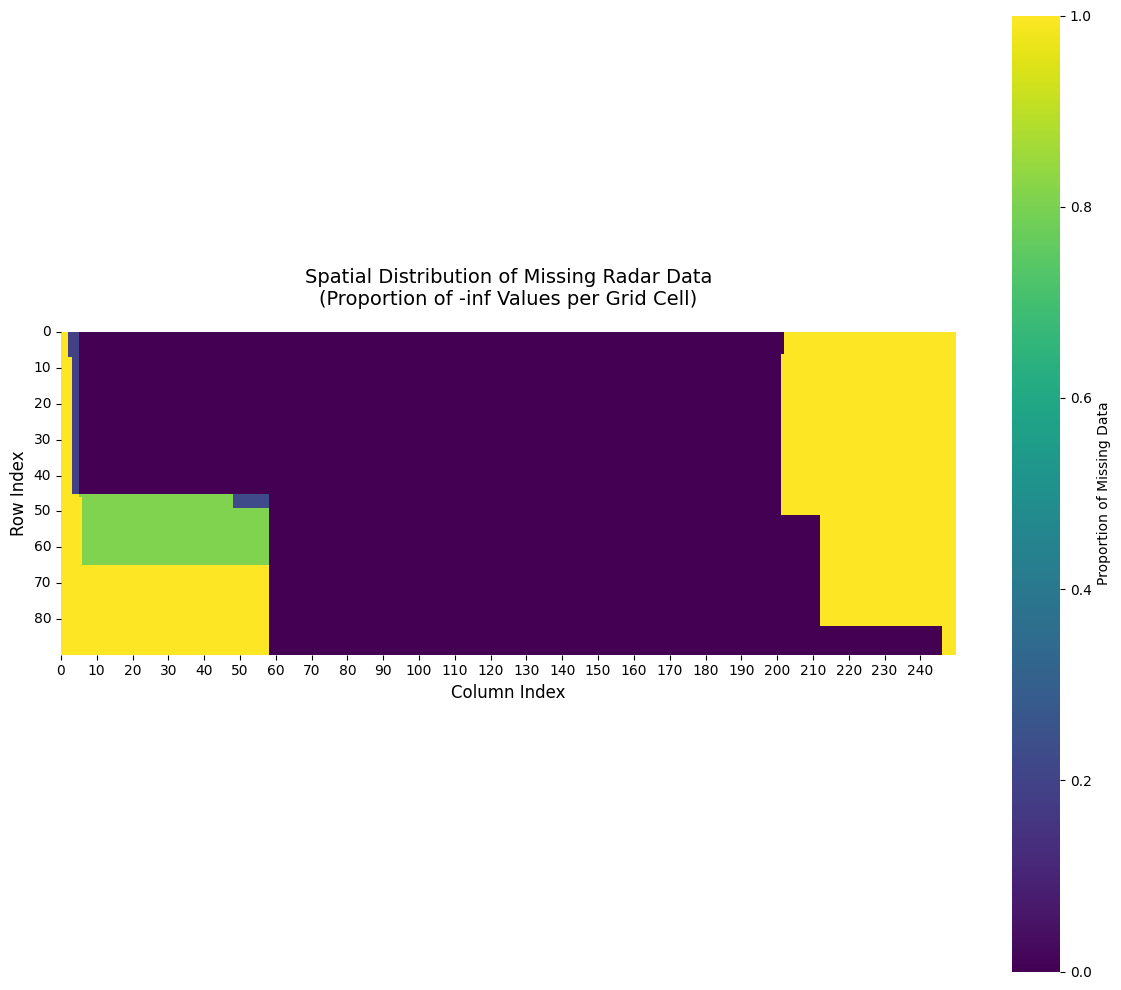

In [73]:
plot_inf_analysis(radar_df)

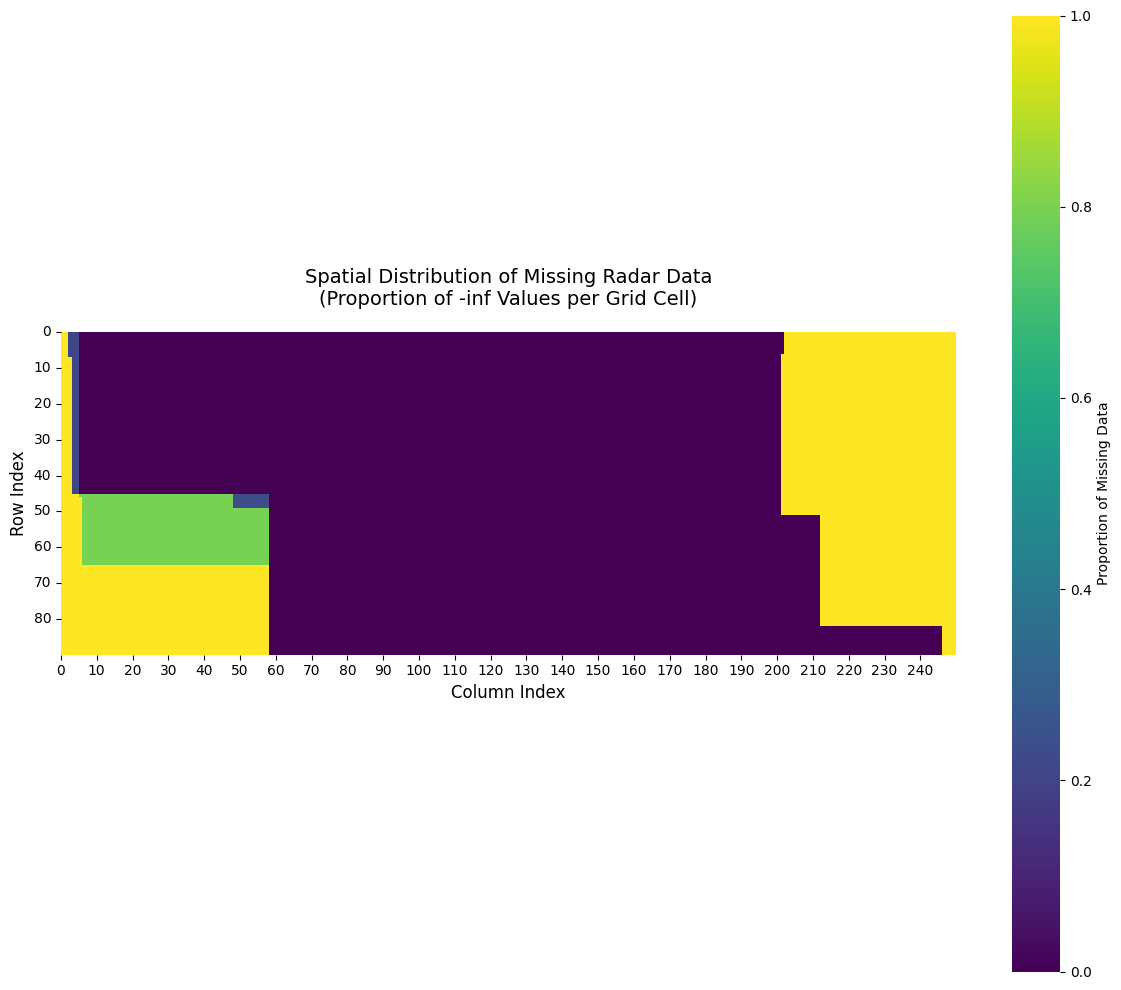

In [74]:
plot_inf_analysis(filtered_radar_df)

## Đếm + plot số pixel < 0, = 0

In [75]:
df = filtered_radar_df.copy()
df['radar'] = pd.to_numeric(df['radar'], errors='coerce')  # In case of string '-inf'
df = df.dropna(subset=['radar'])

# Group key
group_cols = ['year', 'month', 'day', 'hour']


## gtri Radar

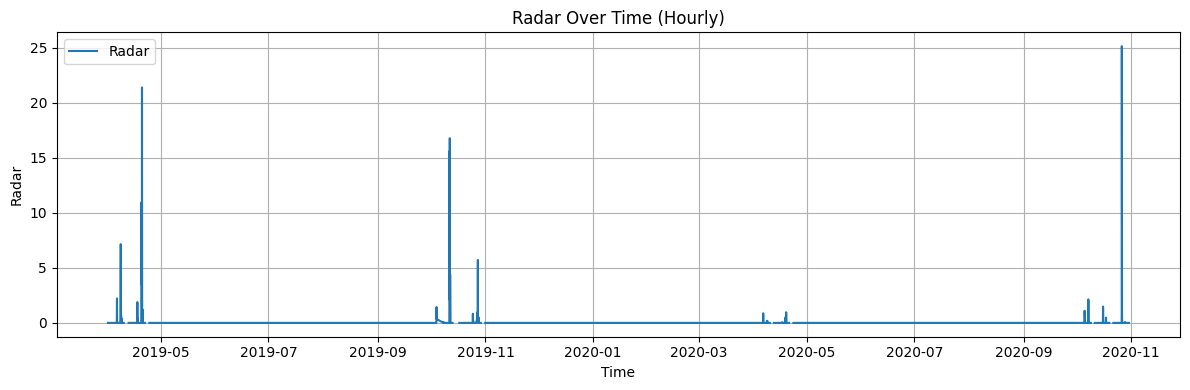

In [94]:
tmp = df.copy()
tmp['timestamp'] = pd.to_datetime(merged_stats[['year', 'month', 'day', 'hour']])
plt.figure(figsize=(12, 4))
plt.plot(tmp['timestamp'], tmp['radar'], label='Radar')
plt.title('Radar Over Time (Hourly)')
plt.xlabel('Time')
plt.ylabel('Radar')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
sum_radar = df[df['radar'] >= 0].groupby(group_cols)['radar'].sum().reset_index(name='radar_sum')
count_stats = df.groupby(group_cols).agg(
    inf_count=('radar', lambda x: (x < 0).sum()),
    positive_count=('radar', lambda x: (x > 0).sum()),
    zero_count = ('radar', lambda x: (x == 0).sum())
).reset_index()
merged_stats = pd.merge(sum_radar, count_stats, on=group_cols, how='outer')
merged_stats['timestamp'] = pd.to_datetime(merged_stats[['year', 'month', 'day', 'hour']])
merged_stats

,year,month,day,hour,radar_sum,inf_count,positive_count,zero_count,timestamp
0,2019,4,1,0,1935.501831,6401,815,15284,2019-04-01 00:00:00
1,2019,4,1,1,1402.737549,6401,761,15338,2019-04-01 01:00:00
2,2019,4,1,2,1763.849976,6401,904,15195,2019-04-01 02:00:00
3,2019,4,1,3,2841.300537,6401,994,15105,2019-04-01 03:00:00
4,2019,4,1,4,5091.975098,6401,1180,14919,2019-04-01 04:00:00
...,...,...,...,...,...,...,...,...,...
2227,2020,10,31,19,5539.509277,6401,535,15564,2020-10-31 19:00:00
2228,2020,10,31,20,3067.541748,6401,510,15589,2020-10-31 20:00:00
2229,2020,10,31,21,1841.482544,6401,493,15606,2020-10-31 21:00:00
2230,2020,10,31,22,547.117493,6401,299,15800,2020-10-31 22:00:00


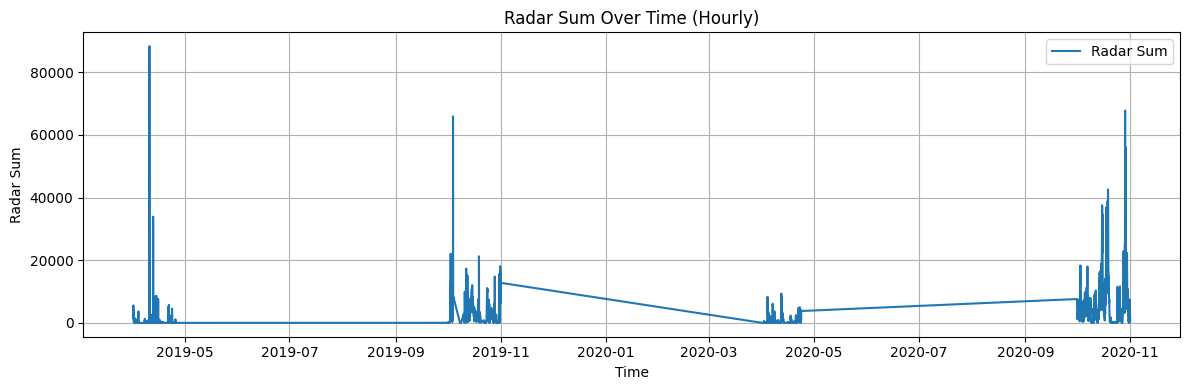

In [77]:
plt.figure(figsize=(12, 4))
plt.plot(merged_stats['timestamp'], merged_stats['radar_sum'], label='Radar Sum')
plt.title('Radar Sum Over Time (Hourly)')
plt.xlabel('Time')
plt.ylabel('Radar Sum')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Tổng lượng mưa và trung bình lượng mưa không phân bố đều, nên phân loại trung bình lượng mưa trc khi chia dữ liệu, khi chia dùng stratify

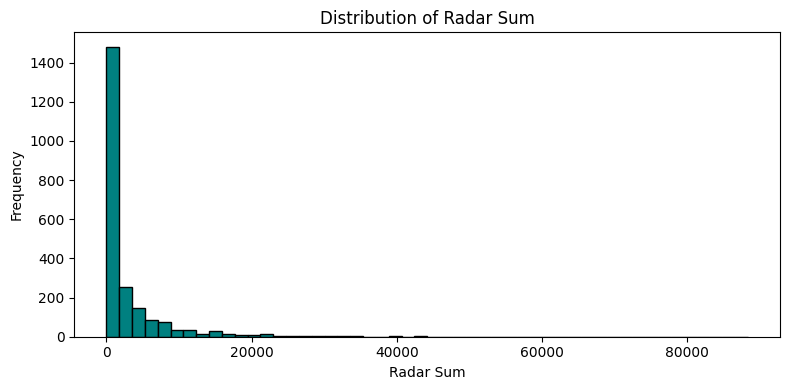

In [78]:
plt.figure(figsize=(8, 4))
plt.hist(merged_stats['radar_sum'], bins=50, color='teal', edgecolor='black')
plt.title('Distribution of Radar Sum')
plt.xlabel('Radar Sum')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

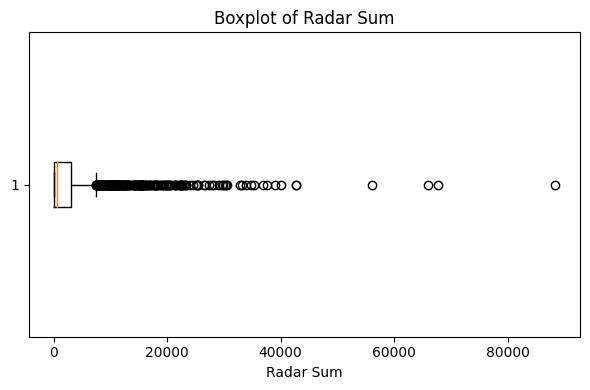

In [79]:
plt.figure(figsize=(6, 4))
plt.boxplot(merged_stats['radar_sum'], vert=False)
plt.title('Boxplot of Radar Sum')
plt.xlabel('Radar Sum')
plt.tight_layout()
plt.show()

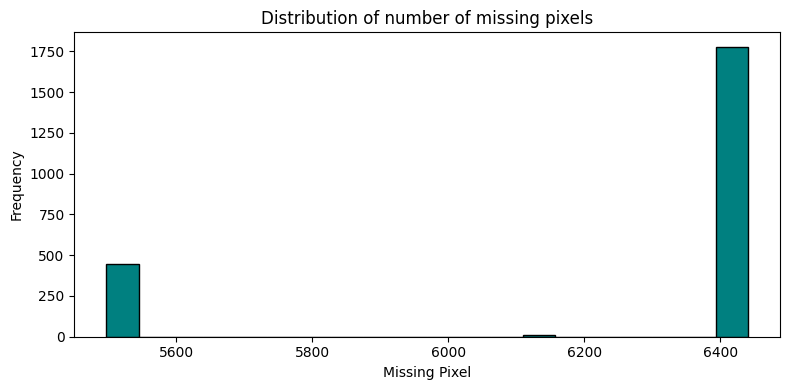

In [80]:
plt.figure(figsize=(8, 4))
plt.hist(merged_stats['inf_count'], bins=20, color='teal', edgecolor='black')
plt.title('Distribution of number of missing pixels')
plt.xlabel('Missing Pixel')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

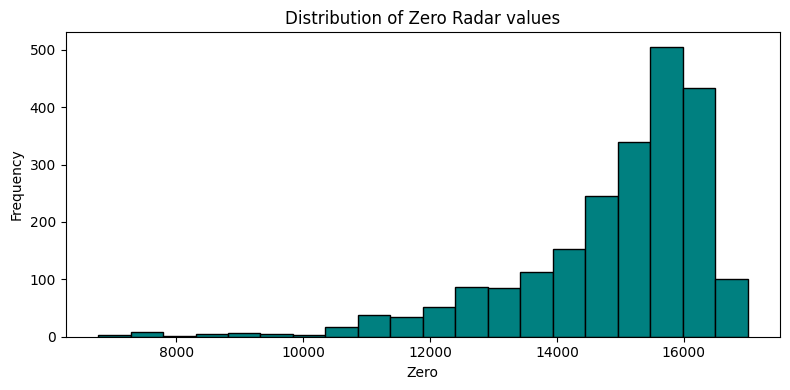

In [81]:
plt.figure(figsize=(8, 4))
plt.hist(merged_stats['zero_count'], bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Zero Radar values')
plt.xlabel('Zero')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

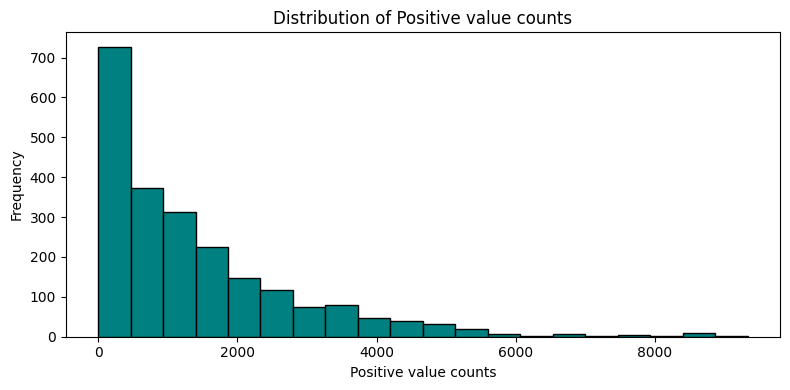

In [82]:
plt.figure(figsize=(8, 4))
plt.hist(merged_stats['positive_count'], bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Positive value counts')
plt.xlabel('Positive value counts')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Phân vị tổng radar

In [83]:
merged_stats['radar_sum'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99, 0.999, 1])

0.000        0.000000
0.250       49.442030
0.500      506.442810
0.750     3030.555481
0.900     7868.723975
0.950    13218.966699
0.970    17543.639199
0.990    27703.860781
0.999    63687.689953
1.000    88359.273438
Name: radar_sum, dtype: float64

In [84]:
merged_stats['radar_mean'] = merged_stats['radar_sum']/merged_stats['positive_count']
merged_stats['radar_mean'] = merged_stats['radar_mean'].fillna(0)

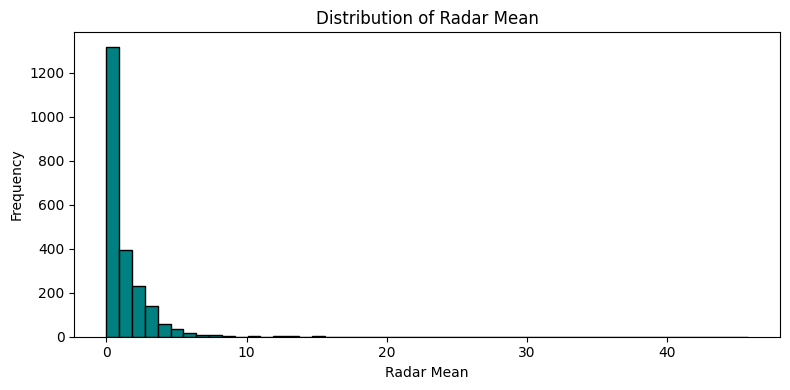

In [85]:
plt.figure(figsize=(8, 4))
plt.hist(merged_stats['radar_mean'], bins=50, color='teal', edgecolor='black')
plt.title('Distribution of Radar Mean')
plt.xlabel('Radar Mean')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Phân vị radar_mean

In [86]:
merged_stats['radar_mean'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99, 0.999, 1])

0.000     0.000000
0.250     0.121111
0.500     0.592736
0.750     1.684924
0.900     3.071274
0.950     4.294596
0.970     5.144170
0.990     8.889736
0.999    38.015832
1.000    45.758298
Name: radar_mean, dtype: float64

In [87]:
merged_stats['positive_count'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99, 0.999, 1])

0.000       0.000
0.250     267.750
0.500     960.000
0.750    1957.500
0.900    3426.500
0.950    4414.650
0.970    4980.120
0.990    6876.030
0.999    8946.487
1.000    9329.000
Name: positive_count, dtype: float64

In [88]:
merged_stats['inf_count'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99, 0.999, 1])

0.000    5497.0
0.250    6401.0
0.500    6401.0
0.750    6401.0
0.900    6441.0
0.950    6441.0
0.970    6441.0
0.990    6441.0
0.999    6441.0
1.000    6441.0
Name: inf_count, dtype: float64

In [89]:
merged_stats['zero_count'].quantile([0, 0.25, 0.5, 0.66, 0.75, 0.9, 0.95, 0.97, 0.99, 0.999, 1])

0.000     6770.00
0.250    14307.25
0.500    15394.50
0.660    15790.46
0.750    15965.00
0.900    16099.00
0.950    16441.50
0.970    16751.21
0.990    16973.38
0.999    17003.00
1.000    17003.00
Name: zero_count, dtype: float64

## Phân loại dựa trên phân vị

In [90]:
def classify_radar_sum(radar_sum):
    if radar_sum == 0:
        return 0
    elif radar_sum <=  510:
        return 1
    elif radar_sum <= 3000:
        return 2
    elif radar_sum <= 7900:
        return 3
    elif radar_sum <= 28000:
        return 4
    else:
        return 5

def classify_radar_mean(radar_mean):
    if radar_mean == 0:
        return 0
    elif radar_mean <= 0.6:
        return 1
    elif radar_mean <= 1.7:
        return 2
    elif radar_mean <= 3:
        return 3
    elif radar_mean <= 8:
        return 4
    else:
        return 5
        
merged_stats['radar_sum_class'] = merged_stats['radar_sum'].apply(classify_radar_sum)
merged_stats['radar_mean_class']= merged_stats['radar_mean'].apply(classify_radar_mean)

In [91]:
merged_stats

,year,month,day,hour,radar_sum,inf_count,positive_count,zero_count,timestamp,radar_mean,radar_sum_class,radar_mean_class
0,2019,4,1,0,1935.501831,6401,815,15284,2019-04-01 00:00:00,2.374849,2,3
1,2019,4,1,1,1402.737549,6401,761,15338,2019-04-01 01:00:00,1.843282,2,3
2,2019,4,1,2,1763.849976,6401,904,15195,2019-04-01 02:00:00,1.951161,2,3
3,2019,4,1,3,2841.300537,6401,994,15105,2019-04-01 03:00:00,2.858451,2,3
4,2019,4,1,4,5091.975098,6401,1180,14919,2019-04-01 04:00:00,4.315233,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2020,10,31,19,5539.509277,6401,535,15564,2020-10-31 19:00:00,10.354223,3,5
2228,2020,10,31,20,3067.541748,6401,510,15589,2020-10-31 20:00:00,6.014788,3,4
2229,2020,10,31,21,1841.482544,6401,493,15606,2020-10-31 21:00:00,3.735259,2,4
2230,2020,10,31,22,547.117493,6401,299,15800,2020-10-31 22:00:00,1.829824,2,3


## Lưu timestamp đã lọc kèm class radar

In [92]:
final_timestamps = merged_stats[['year', 'month', 'day','hour', 'radar_mean_class', 'radar_sum_class']]
final_timestamps

,year,month,day,hour,radar_mean_class,radar_sum_class
0,2019,4,1,0,3,2
1,2019,4,1,1,3,2
2,2019,4,1,2,3,2
3,2019,4,1,3,3,2
4,2019,4,1,4,4,3
...,...,...,...,...,...,...
2227,2020,10,31,19,5,3
2228,2020,10,31,20,4,3
2229,2020,10,31,21,4,2
2230,2020,10,31,22,3,2


In [93]:
final_timestamps.to_csv('final_rain_timestamps.csv')